In [8]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['figure.dpi'] = 200
from utils import *

In [9]:
lamda = 0.2
min_distance = 0.1 
t = 200
snr = 20
nbSources = 5

In [10]:
array = UniformRectangularArray(lamda=lamda, min_distance=min_distance, size_horizontal=35, size_vertical=34)
array.build_coarray()
array.build_array_manifold()

In [11]:
phi = generate_angles(nbSources, 0, np.pi)
theta = generate_angles(nbSources, 0, np.pi/2)
S = (np.random.randn(nbSources, t) + 1j * np.random.randn(nbSources, t)) / sqrt(2)
X = array.get_steering_vector(phi, theta) @ S

In [12]:
cov = X @ X.T.conj() / X.shape[1]

coarray_covariance = {}
for pos, indices in array.pos_coarray_dict.items():
    indices = np.array(indices)
    values = np.mean(cov[indices[:, 0], indices[:, 1]]).conj()
    coarray_covariance[pos] = values

R = np.zeros((69, 67), dtype=np.complex64)
for pos in array.pos_coarray_dict.keys():
    R[pos[0] + 34, pos[1] + 33] = coarray_covariance[pos]

U_svd, S_svd, Vh_svd = np.linalg.svd(R)

In [13]:
phi_discretized = np.linspace(0, np.pi, 360, endpoint=False)
theta_discretized = np.linspace(0, np.pi/2, 180, endpoint=False)

U = np.exp(-1j * 2 * np.pi * min_distance / lamda * np.cos(phi_discretized).reshape(1, -1, 1)
                                                  * np.sin(theta_discretized).reshape(1, 1, -1)
                                                  * np.arange(-34, 35).reshape(-1, 1, 1))

V = np.exp(1j * 2 * np.pi * min_distance / lamda * np.sin(phi_discretized).reshape(1, -1, 1)
                                                 * np.sin(theta_discretized).reshape(1, 1, -1)
                                                 * np.arange(-33, 34).reshape(-1, 1, 1))

spectrum = 1 / (np.linalg.norm(np.einsum('ij,ikl->jkl', U_svd[:, nbSources:].conj(), U), axis=0) ** 2 + 
                np.linalg.norm(np.einsum('ji,ikl->jkl', Vh_svd[nbSources:, :], V), axis=0) ** 2)

We consider the following equation in the case of no noise:
$$
\mathbf{R} = \mathbf{U}(\boldsymbol{\phi}, \boldsymbol{\theta}) \, \mathbf{S} \, \mathbf{V}(\boldsymbol{\phi}, \boldsymbol{\theta})^{H}
$$

where:

- $\mathbf{S} = \text{diag}(\sigma_{1}^{2}, \sigma_{2}^{2}, ..., \sigma_{K}^{2})$

- $\mathbf{U}(\boldsymbol{\phi}, \boldsymbol{\theta}) \in \mathbb{C}^{(2A+1)\times K}$ is a matrix whose columns are defined as:
  $$
  \mathbf{u}(\phi_k, \theta_k) = \left\{ e^{-j \frac{2\pi d}{\lambda} \cos(\phi_k) \sin(\theta_k) \, r} \right\}_{r = -A}^{A}
  $$

- $\mathbf{V}(\boldsymbol{\phi}, \boldsymbol{\theta}) \in \mathbb{C}^{(2B+1)\times K}$ is a matrix whose columns are defined as:
  $$
  \mathbf{v}(\phi_k, \theta_k) = \left\{ e^{j \frac{2\pi d}{\lambda} \sin(\phi_k) \sin(\theta_k) \, s} \right\}_{s = -B}^{B}
  $$

We take the SVD of $\mathbf{R}=\mathbf{XDY}^{H}$ and let $\mathbf{\underline{X}}$ and $\mathbf{\underline{Y}}$ respectively be the last $2A+1-K$ columns of $\mathbf{X}$ and last $2B+1-K$ columns of $\mathbf{Y}$. The two following equalities hold for each $k$:
$$
\begin{cases}
  \|\mathbf{\underline{X}}^{H}\mathbf{u}(\phi_k, \theta_k)\|=0 \\
  \|\mathbf{\underline{Y}}^{H}\mathbf{v}(\phi_k, \theta_k)\|=0
\end{cases}
$$

Thus we can define the pseudo spectrum as:
$$ P(\phi, \theta) = \frac{1}{\|\mathbf{\underline{X}}^{H}\mathbf{u}(\phi, \theta)\|^{2}+\|\mathbf{\underline{Y}}^{H}\mathbf{v}(\phi, \theta)\|^{2}}

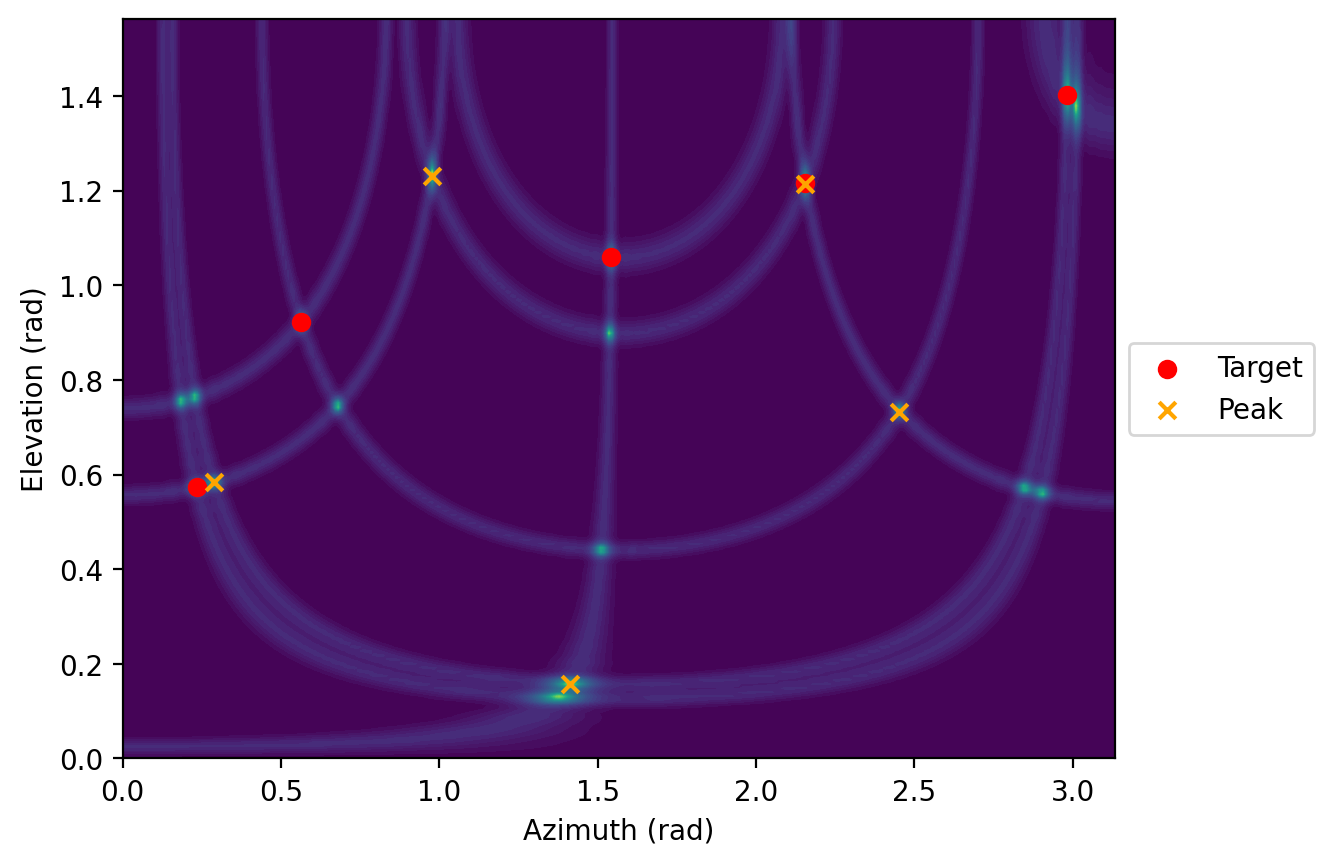

In [ ]:
def MUSIC_peak_finding_2D(spectrum, d: int):

    neighborhood = generate_binary_structure(2, 2)
    local_max = (spectrum == maximum_filter(spectrum, footprint=neighborhood))
    labeled_peaks, _ = label(local_max)
    peak_coords = np.argwhere(labeled_peaks)
    peak_coords_flatten = peak_coords[:, 0] * spectrum.shape[1] + peak_coords[:, 1]
    spectrum_flatten = spectrum.flatten()
    sort_idx = np.argsort(-spectrum_flatten[peak_coords_flatten])
    selected_coords_sort = peak_coords_flatten[sort_idx][:d]
    peak_coords_theta = selected_coords_sort // spectrum.shape[1]
    peak_coords_phi = selected_coords_sort % spectrum.shape[1]
    return peak_coords_phi, peak_coords_theta 


def plot_spectrum(axe, spectrum, phi_space, theta_space, phi_true, theta_true):
    
    phi_plot, theta_plot = np.meshgrid(phi_space, theta_space)
    spectrum = 10 * np.log10(spectrum / np.max(spectrum))  
    
    contour = axe.contourf(phi_plot, theta_plot, spectrum.T, levels=50, cmap='viridis')

    peak_coords_phi, peak_coords_theta = MUSIC_peak_finding_2D(spectrum.T, phi_true.shape[-1])
    phi_predicted = phi_space[peak_coords_phi]
    theta_predicted = theta_space[peak_coords_theta]

    axe.scatter(phi_true, theta_true, color='red', marker='o', label="Target")
    axe.scatter(phi_predicted, theta_predicted, color='orange', marker='x', label="Peak")

    axe.set_xlabel('Azimuth (rad)')
    axe.set_ylabel('Elevation (rad)')
    axe.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_spectrum(spectrum, phi_discretized, theta_discretized, phi, theta)